<a href="https://colab.research.google.com/github/amalazimroshan/volkswagon/blob/main/object_detection_depth_estimation_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/amalazimroshan/volkswagon.git

Cloning into 'volkswagon'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 55 (delta 14), reused 46 (delta 9), pack-reused 0
Receiving objects: 100% (55/55), 7.96 MiB | 30.86 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [2]:
%cd volkswagon/

/content/volkswagon


In [3]:
import copy
import math

import requests

import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import torch
import torchvision
import torchvision.transforms.functional as tvtf
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights,MaskRCNN_ResNet50_FPN_V2_Weights

#this is the file with auxillary functions. stereo_image_utils.py. Should be in the same
#directory as the notebook
import stereo_image_utils
from stereo_image_utils import get_detections, get_cost, draw_detections, annotate_class2
from stereo_image_utils import get_horiz_dist_corner_tl, get_horiz_dist_corner_br, get_dist_to_centre_tl, get_dist_to_centre_br

In [4]:
image_left = cv2.imread("/content/volkswagon/test_images/left.jpg")
image_right = cv2.imread("/content/volkswagon/test_images/right.jpg")

In [5]:
image_left

array([[[255, 255, 241],
        [254, 254, 242],
        [253, 251, 243],
        ...,
        [ 77,  62,  43],
        [ 76,  61,  42],
        [ 74,  59,  40]],

       [[253, 253, 237],
        [255, 254, 240],
        [253, 251, 243],
        ...,
        [ 77,  62,  43],
        [ 76,  61,  42],
        [ 74,  59,  40]],

       [[252, 250, 232],
        [253, 253, 237],
        [253, 252, 242],
        ...,
        [ 78,  63,  44],
        [ 77,  62,  43],
        [ 76,  61,  42]],

       ...,

       [[132, 121,  89],
        [131, 120,  88],
        [132, 121,  89],
        ...,
        [102,  90,  66],
        [102,  90,  66],
        [103,  91,  67]],

       [[133, 122,  90],
        [133, 122,  90],
        [135, 124,  92],
        ...,
        [102,  90,  66],
        [102,  90,  66],
        [102,  90,  66]],

       [[133, 122,  90],
        [133, 122,  90],
        [136, 125,  93],
        ...,
        [102,  90,  66],
        [102,  90,  66],
        [102,  90,  66]]

In [9]:
weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT

COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in plt.rcParams['axes.prop_cycle'].by_key()['color']
]

In [10]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights)
_ = model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:04<00:00, 39.6MB/s]


In [11]:
imgs = [cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB),cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB)]

In [12]:
det, lbls, scores, masks = get_detections(model,imgs)

In [13]:
print(det,lbls,scores,masks)

[array([[505.38153 , 213.86559 , 866.34875 , 395.91183 ],
       [  0.      , 193.12543 ,  44.464584, 239.56375 ],
       [389.8563  , 191.85622 , 404.83783 , 201.61623 ],
       [ 37.489433, 177.40515 , 143.79689 , 264.17313 ],
       [133.50262 , 184.01927 , 185.68575 , 207.45415 ],
       [476.4581  , 190.53725 , 492.43512 , 205.66516 ],
       [436.9778  , 189.16112 , 445.99213 , 196.09471 ],
       [568.4572  , 118.15624 , 590.81903 , 127.986496],
       [626.31146 , 166.34787 , 635.0821  , 189.04134 ],
       [461.50433 , 187.3434  , 472.43808 , 196.89018 ]], dtype=float32), array([[4.61170654e+02, 2.15216568e+02, 7.90318542e+02, 3.93982941e+02],
       [3.85781677e+02, 1.91446320e+02, 4.00796051e+02, 2.01610031e+02],
       [3.21333438e-01, 1.94212570e+02, 2.33305721e+01, 2.37779968e+02],
       [1.23955841e+02, 1.83754257e+02, 1.79765137e+02, 2.07136261e+02],
       [5.59530029e+02, 1.17820358e+02, 5.82535828e+02, 1.27004745e+02],
       [4.72134552e+02, 1.90498138e+02, 4.88744

In [14]:
sz1 = image_right.shape[1]
center = sz1/2
center

440.5

In [15]:
lbls

[array([ 3,  3,  3,  3,  3,  3,  3, 10, 10,  3, 10,  1, 10,  3,  4,  3, 10,
        10,  1, 10,  1,  3, 10, 10, 10]),
 array([ 3,  3,  3,  3, 10,  3,  3,  3, 10, 10,  3, 10,  1,  3, 10,  3,  3,
         3,  1, 10, 10, 10,  8, 37, 10])]

In [16]:
print(np.array(weights.meta["categories"])[lbls[0]])

['car' 'car' 'car' 'car' 'car' 'car' 'car' 'traffic light' 'traffic light'
 'car' 'traffic light' 'person' 'traffic light' 'car' 'motorcycle' 'car'
 'traffic light' 'traffic light' 'person' 'traffic light' 'person' 'car'
 'traffic light' 'traffic light' 'traffic light']


In [17]:
print(np.array(weights.meta["categories"])[lbls[1]])

['car' 'car' 'car' 'car' 'traffic light' 'car' 'car' 'car' 'traffic light'
 'traffic light' 'car' 'traffic light' 'person' 'car' 'traffic light'
 'car' 'car' 'car' 'person' 'traffic light' 'traffic light'
 'traffic light' 'truck' 'sports ball' 'traffic light']


In [18]:
cost = get_cost(det, lbls = lbls,sz1 = center)
cost

array([[7.71659851e+01, 9.83210068e+02, 1.26540316e+03, 1.22743707e+03,
        5.16759108e+04, 8.89103516e+02, 9.57615417e+02, 1.16726673e+03,
        5.13513954e+04, 5.14337790e+04],
       [6.60528848e+03, 3.81398909e+03, 1.45597248e+01, 1.40250380e+03,
        5.64618747e+04, 4.67853886e+03, 4.29455962e+03, 4.86825473e+02,
        5.67036519e+04, 5.53757152e+04],
       [2.95653838e+03, 5.11292212e+00, 4.83765146e+02, 2.54571856e+02,
        5.26086252e+04, 8.36854264e+02, 4.41014640e+02, 4.71478045e+02,
        5.28503464e+04, 5.15221702e+04],
       [5.88270458e+03, 3.16835567e+03, 1.21445827e+02, 7.56870384e+02,
        5.58162413e+04, 4.03290544e+03, 3.64892620e+03, 2.45317926e+01,
        5.60580185e+04, 5.47300817e+04],
       [5.33662039e+03, 2.34333406e+03, 2.49566520e+02, 9.37719512e+00,
        5.49833051e+04, 3.22137564e+03, 2.81599000e+03, 2.36278502e+02,
        5.52250823e+04, 5.38971455e+04],
       [2.07850127e+03, 9.92251215e+01, 5.63823068e+02, 3.48279528e+02,
   

In [19]:
tracks = scipy.optimize.linear_sum_assignment(cost)
tracks

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 2, 1, 7, 3, 5, 6, 4, 8, 9]))

In [20]:
dists_tl =  get_horiz_dist_corner_tl(det)
dists_br =  get_horiz_dist_corner_br(det)
print(dists_tl,dists_br)

[[ 4.42108765e+01  1.19599854e+02  5.05060197e+02  3.81425690e+02
  -5.41484985e+01  3.32469788e+01  7.07680054e+01  4.90841612e+02
  -1.12820312e+02  1.32749329e+01]
 [-4.61170654e+02 -3.85781677e+02 -3.21333438e-01 -1.23955841e+02
  -5.59530029e+02 -4.72134552e+02 -4.34613525e+02 -1.45399189e+01
  -6.18201843e+02 -4.92106598e+02]
 [-7.13143616e+01  4.07461548e+00  3.89534959e+02  2.65900452e+02
  -1.69673737e+02 -8.22782593e+01 -4.47572327e+01  3.75316374e+02
  -2.28345551e+02 -1.02250305e+02]
 [-4.23681221e+02 -3.48292244e+02  3.71680999e+01 -8.64664078e+01
  -5.22040596e+02 -4.34645119e+02 -3.97124092e+02  2.29495144e+01
  -5.80712410e+02 -4.54617165e+02]
 [-3.27668030e+02 -2.52279053e+02  1.33181291e+02  9.54678345e+00
  -4.26027405e+02 -3.38631927e+02 -3.01110901e+02  1.18962706e+02
  -4.84699219e+02 -3.58603973e+02]
 [ 1.52874451e+01  9.06764221e+01  4.76136766e+02  3.52502258e+02
  -8.30719299e+01  4.32354736e+00  4.18445740e+01  4.61918180e+02
  -1.41743744e+02 -1.56484985e+01

In [21]:
final_dists = []
dctl = get_dist_to_centre_tl(det[0],cntr = center)
dcbr = get_dist_to_centre_br(det[0], cntr = center)
print(dctl,dcbr)

[ 64.88153076 440.5         50.64370728 403.01056671 306.99737549
  35.95809937   3.52218628 127.95721436 185.8114624   21.0043335 ] [425.84875488 396.03541565  35.66217041 296.70310974 254.81425476
  51.93511963   5.49212646 150.31903076 194.58209229  31.93807983]


In [22]:
for i, j in zip(*tracks):
  if dctl[i] < dcbr[i]:
    final_dists.append((dists_tl[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
  else:
    final_dists.append((dists_br[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
final_dists

[(44.21087646484375, 'car'),
 (21.13401222229004, 'car'),
 (4.041778564453125, 'car'),
 (24.261383056640625, 'car'),
 (5.9206085205078125, 'car'),
 (4.32354736328125, 'car'),
 (2.364288330078125, 'car'),
 (8.92718505859375, 'traffic light'),
 (8.109619140625, 'traffic light'),
 (-30.602264404296875, 'car')]

In [23]:
fd = [i for (i,j) in final_dists]
fd

[44.21087646484375,
 21.13401222229004,
 4.041778564453125,
 24.261383056640625,
 5.9206085205078125,
 4.32354736328125,
 2.364288330078125,
 8.92718505859375,
 8.109619140625,
 -30.602264404296875]

In [24]:
#find distance away
# fl = 2.043636363636363
fl = 45
tantheta = 0.7648732789907391
dists_away = (7.05/2)*sz1*(1/tantheta)/np.array((fd))+fl
dists_away

array([ 136.83673094,  237.11602245, 1049.55339198,  212.35164508,
        730.77112513,  984.08589993, 1762.29577772,  499.81104513,
        545.6625214 ,  -87.67588022])

In [25]:
cat_dist = []
for i in range(len(dists_away)):
    cat_dist.append(f'{np.array(weights.meta["categories"])[lbls[0]][(tracks[0][i])]} {dists_away[i]:.1f}cm')
    print(f'{np.array(weights.meta["categories"])[lbls[0]][(tracks[0][i])]} is {dists_away[i]:.1f}cm away')
cat_dist

car is 136.8cm away
car is 237.1cm away
car is 1049.6cm away
car is 212.4cm away
car is 730.8cm away
car is 984.1cm away
car is 1762.3cm away
traffic light is 499.8cm away
traffic light is 545.7cm away
car is -87.7cm away


['car 136.8cm',
 'car 237.1cm',
 'car 1049.6cm',
 'car 212.4cm',
 'car 730.8cm',
 'car 984.1cm',
 'car 1762.3cm',
 'traffic light 499.8cm',
 'traffic light 545.7cm',
 'car -87.7cm']

In [26]:
t1 = [list(tracks[1]), list(tracks[0])]
t1

[[0, 2, 1, 7, 3, 5, 6, 4, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [27]:
from google.colab.patches import cv2_imshow

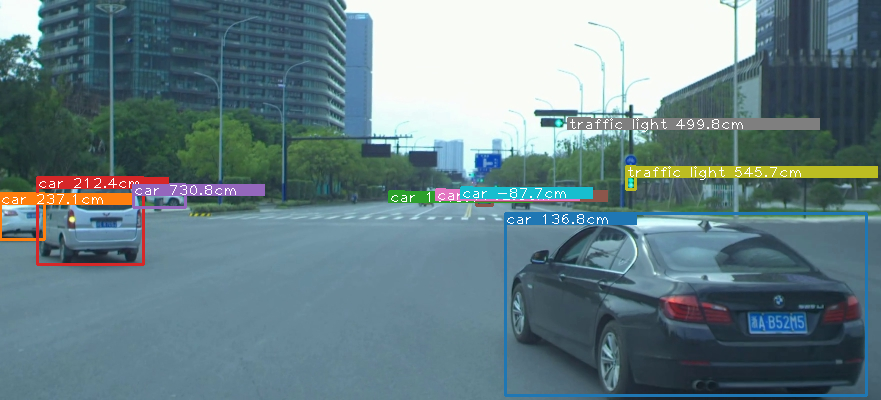

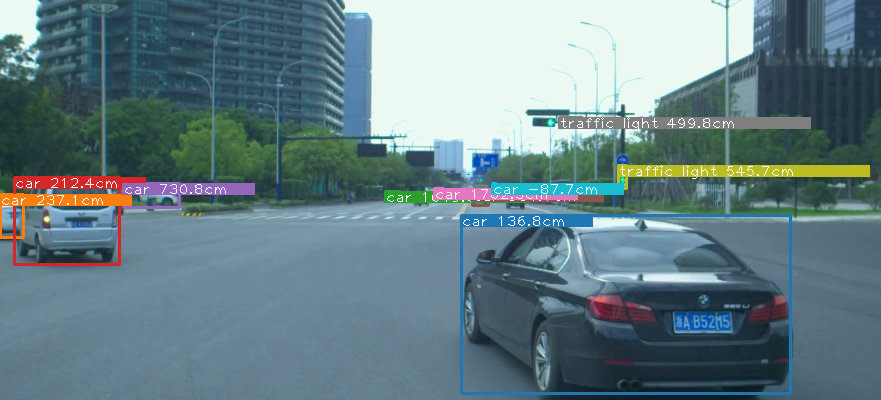

In [28]:
frames_ret = []
for i, imgi in enumerate(imgs):
  img = imgi.copy()
  deti = det[i].astype(np.int32)
  draw_detections(img,deti[list(tracks[i])], obj_order=list(t1[1]))
  annotate_class2(img,deti[list(tracks[i])],lbls[i][list(tracks[i])],cat_dist)
  frames_ret.append(img)
cv2_imshow( cv2.cvtColor(frames_ret[0],cv2.COLOR_RGB2BGR))
cv2_imshow( cv2.cvtColor(frames_ret[1],cv2.COLOR_RGB2BGR))